In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import re

from math import sin, cos, sqrt, atan2, radians

from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud

import folium
from folium.plugins import FastMarkerCluster

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# import data
cus=pd.read_csv('https://www.dropbox.com/s/df95i66oe1ey5ow/olist_customers_dataset.csv?dl=1')
loc=pd.read_csv('https://www.dropbox.com/s/4mbuhr19xxhjlu4/olist_geolocation_dataset.csv?dl=1')
ord=pd.read_csv('https://www.dropbox.com/s/uu8b1e0sjb3ql01/olist_order_items_dataset.csv?dl=1')
pay=pd.read_csv('https://www.dropbox.com/s/vt7mdzhdhl6i1z0/olist_order_payments_dataset.csv?dl=1')
rv=pd.read_csv('https://www.dropbox.com/s/f88iovhz8yezax9/olist_order_reviews_dataset.csv?dl=1')
ord_stt=pd.read_csv('https://www.dropbox.com/s/i3kz1jtwm0n027k/olist_orders_dataset.csv?dl=1')
sel=pd.read_csv('https://www.dropbox.com/s/1o6c5fdv19hs0el/olist_sellers_dataset.csv?dl=1')

prd_brz=pd.read_csv('https://www.dropbox.com/s/3n3lesk9004kl7e/olist_products_dataset.csv?dl=1')
prd_eng=pd.read_csv('https://www.dropbox.com/s/daisqykf95os6af/product_category_name_translation.csv?dl=1')

prd=pd.merge(prd_brz,prd_eng,how='left',on='product_category_name').drop(columns='product_category_name')

# data name
data_name={'cus':'olist_customers_dataset','loc':'olist_geolocation_dataset',
      'ord':'olist_order_items_dataset','pay':'olist_order_payments_dataset',
      'rv':'olist_order_reviews_dataset','ord_stt':'olist_orders_dataset',
      'sel':'olist_sellers_dataset.csv','prd':'product_category_name'}

# Data Cleaning

In [3]:
df_name=('customers (cus)','geolocation (loc)','order_items (ord)','order_payments (pay)',
         'order_reviews (rv)','orders (ord_stt)','products (prd)','sellers (sel)')
lst=[]
tmp=0
for i in cus,loc,ord,pay,rv,ord_stt,prd,sel:
  dic={}
  dic['dataset']=df_name[tmp]
  dic['n_rows']=i.shape[0]
  dic['n_cols']=i.shape[1]
  dic['null_vals']=i.isna().sum().sum()
  dic['dupl_vals']=i.duplicated().sum()
  tmp=tmp+1
  lst.append(dic)
ovv_check=pd.DataFrame(data=lst, columns=lst[0].keys())
ovv_check

dataset   n_rows  n_cols  null_vals  dupl_vals
0       customers (cus)    99441       5          0          0
1     geolocation (loc)  1000163       5          0     261831
2     order_items (ord)   112650       7          0          0
3  order_payments (pay)   103886       5          0          0
4    order_reviews (rv)    99224       7     145903          0
5      orders (ord_stt)    99441       8       4908          0
6        products (prd)    32951       9       2461          0
7         sellers (sel)     3095       4          0          0

In [4]:
null=pd.DataFrame()
for i in rv,ord_stt,prd:
  i=i.isna().sum().reset_index()
  i=i[i[0]!=0]
  null=pd.concat([null,i])
null=null.reset_index().drop(columns='level_0').rename(columns={'index':'null_col',0:'null_qty'})
def columns_check(x):
  if x in rv.columns:
    return 'order_reviews (rv)'
  if x in ord_stt.columns:
    return 'orders (ord_stt)'
  if x in prd.columns:
    return 'products (prd)'    
null['dataset']=null['null_col'].apply(columns_check)
null=null.reindex(columns=['dataset','null_col','null_qty'])
null

dataset                       null_col  null_qty
0   order_reviews (rv)           review_comment_title     87656
1   order_reviews (rv)         review_comment_message     58247
2     orders (ord_stt)              order_approved_at       160
3     orders (ord_stt)   order_delivered_carrier_date      1783
4     orders (ord_stt)  order_delivered_customer_date      2965
5       products (prd)            product_name_lenght       610
6       products (prd)     product_description_lenght       610
7       products (prd)             product_photos_qty       610
8       products (prd)               product_weight_g         2
9       products (prd)              product_length_cm         2
10      products (prd)              product_height_cm         2
11      products (prd)               product_width_cm         2
12      products (prd)  product_category_name_english       623

In [5]:
# change any timeline columns to datetime type
for i in ('order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
          'order_delivered_customer_date','order_estimated_delivery_date'):
  ord_stt[i]=pd.to_datetime(ord_stt[i])
for i in 'review_creation_date','review_answer_timestamp':
  rv[i]=pd.to_datetime(rv[i])
ord['shipping_limit_date']=pd.to_datetime(ord['shipping_limit_date'])

In [6]:
# remove not_defined in payment_type column
pay=pay[~pay['payment_type'].isin(['not_defined'])]

In [7]:
ord_stt.groupby(ord_stt['order_purchase_timestamp'].dt.to_period('M')).count()['order_id']

order_purchase_timestamp
2016-09       4
2016-10     324
2016-12       1
2017-01     800
2017-02    1780
2017-03    2682
2017-04    2404
2017-05    3700
2017-06    3245
2017-07    4026
2017-08    4331
2017-09    4285
2017-10    4631
2017-11    7544
2017-12    5673
2018-01    7269
2018-02    6728
2018-03    7211
2018-04    6939
2018-05    6873
2018-06    6167
2018-07    6292
2018-08    6512
2018-09      16
2018-10       4
Freq: M, Name: order_id, dtype: int64

In [8]:
# series above lack of data in 2016-09,2016-10,2016-12,2018-09,2018-10 --> remove any order_id exised in those month
eli_ord=[]
def eli_month(x):
  if re.findall('2016-09|2016-10|2016-11|2016-12|2018-09|2018-10',str(x['order_purchase_timestamp'])):
    eli_ord.append(x['order_id'])
ord_stt.apply(eli_month,axis=1)
ord=ord[~ord['order_id'].isin(eli_ord)]
pay=pay[~pay['order_id'].isin(eli_ord)]
rv=rv[~rv['order_id'].isin(eli_ord)]
ord_stt=ord_stt[~ord_stt['order_id'].isin(eli_ord)]

In [9]:
# location
avg_lat_lng=(loc.drop_duplicates()).groupby('geolocation_zip_code_prefix').mean()[['geolocation_lat','geolocation_lng']].reset_index()
city=loc[['geolocation_zip_code_prefix','geolocation_city','geolocation_state']].drop_duplicates(subset=['geolocation_zip_code_prefix'])
loc=pd.merge(avg_lat_lng,city,on='geolocation_zip_code_prefix',how='inner')
loc

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                             1001       -23.550227       -46.634039   
1                             1002       -23.547657       -46.634991   
2                             1003       -23.549000       -46.635582   
3                             1004       -23.549829       -46.634792   
4                             1005       -23.549547       -46.636406   
...                            ...              ...              ...   
19010                        99960       -27.953722       -52.025511   
19011                        99965       -28.183372       -52.039850   
19012                        99970       -28.343920       -51.874988   
19013                        99980       -28.389500       -51.843122   
19014                        99990       -28.329595       -51.769362   

      geolocation_city geolocation_state  
0            sao paulo                SP  
1            sao paulo                SP  
2            sao paulo                SP  
3            sao paulo                SP  
4            sao paulo                SP  
...                ...               ...  
19010          charrua                RS  
19011       agua santa                RS  
19012          ciriaco                RS  
19013  david canabarro                RS  
19014        muliterno                RS  

[19015 rows x 5 columns]

# Exploratory Data Analysis

<AxesSubplot:xlabel='order_purchase_timestamp'>

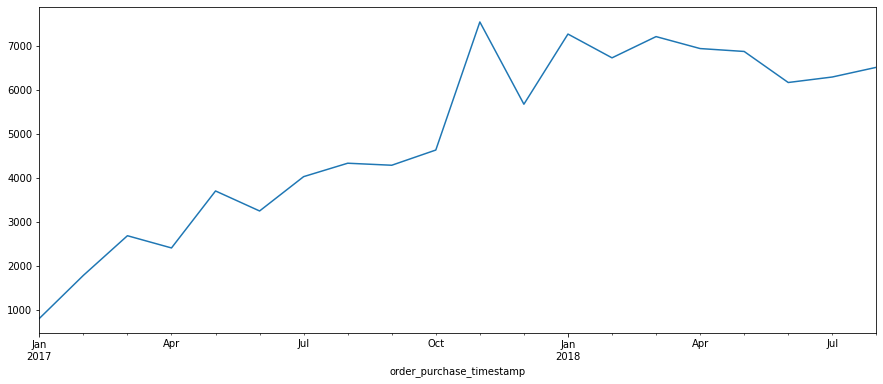

In [10]:
# number of orders by year month
ord_stt.groupby(ord_stt['order_purchase_timestamp'].dt.to_period('M')).count()['order_id'].plot(figsize=(15,6))

***2 questions here:***

**1.  Why number of orders have unusual changes at the end of 2017 and early 2018 ?**

**2.  Why number of orders have been trending sideways since Feb-2018 ?**



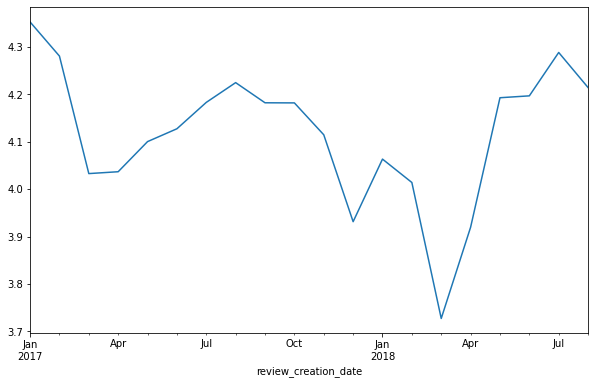

In [11]:
rv.groupby(rv['review_creation_date'].dt.to_period('M')).mean()['review_score'].plot(figsize=(10,6))
plt.show()

***--> The number of reviews also decreased unusually since the end of 2017***

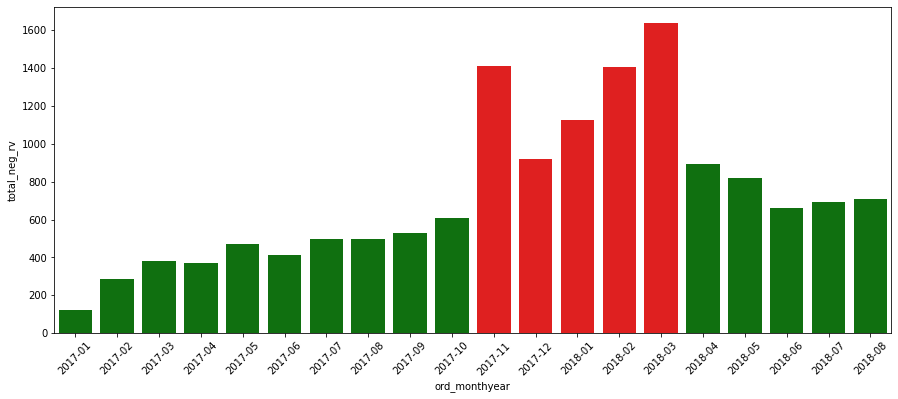

In [12]:
neg_rv=rv.copy()[(rv['review_score']==1) | (rv['review_score']==2)][['review_id','order_id','review_score','review_creation_date','review_answer_timestamp']]
neg_rv=pd.merge(neg_rv,ord_stt[['order_id','order_purchase_timestamp']],on='order_id',how='left')
neg_rv['ord_monthyear']=neg_rv['order_purchase_timestamp'].dt.to_period('M')
neg_rv_month=neg_rv.groupby('ord_monthyear').count()['review_id'].reset_index().rename(columns={'review_id':'total_neg_rv'})

color=[]
for i in range(0,neg_rv_month.shape[0]):
  if i<10:
    color.append('green')
  elif i<15:
    color.append('red')
  else:
    color.append('green')

plt.figure(figsize=(15,6))
sns.barplot(data=neg_rv_month,
            x='ord_monthyear',
            y='total_neg_rv',
            palette=color)
plt.xticks(rotation=45)

plt.show()

***--> There are lots of 1 & 2 star since '2017-11' in review score --> Let's analyse negative comment of customers to see what happens***

In [13]:
neg_cmt_rv=rv.copy()[['review_id','order_id','review_comment_message']].dropna()

In [14]:
pt_stopwords = stopwords.words('portuguese')
def clean_cmt(txt):
  txt=re.sub('''\r|\n|\.|,|$|!|\d|\?''','',txt)
  
  txt=txt.lower()

  result=[]
  for i in txt.split():
    if i not in pt_stopwords:
        result.append(i)
  txt = ' '.join(result)
  return txt

neg_cmt_rv['new_cmt']=neg_cmt_rv['review_comment_message'].apply(clean_cmt)

In [15]:
dic={}
def cmt_count(txt):
  for i in txt.split():
    if i not in dic:
      dic[i] = 1
    elif i in dic:
      dic[i]+= 1  
neg_cmt_rv['new_cmt'].apply(cmt_count)

pd.Series(dic).sort_values(ascending=False)[:10].reset_index().rename(columns={'index':'word',0:'counts'})

word  counts
0    produto   17811
1      prazo    8040
2    entrega    6240
3      antes    5554
4     chegou    5370
5     recebi    5145
6        bom    4458
7  recomendo    3971
8   entregue    3673
9       veio    3214

*As word count above we can see almost customers complain about 2 things:*

- **Products with low quality, wrong model and can not be exchanged --> Product 's quality**

- **Slow delivery, not as expected, damage package ... --> Delivery**

**--> Big question: How does delivery affect order quantity ?**

In [16]:
# function to calculate growth & growth ratio
def growth_cal(data,feature):
  ord_growth=[None]
  ord_growth_ratio=[None]
  for i in range(1,data.shape[0]):
    x=data[feature][i]-data[feature][i-1]
    ord_growth.append(x)
    y=(data[feature][i]-data[feature][i-1])/data[feature][i-1]
    ord_growth_ratio.append(round(y,2))
  growth=pd.concat([pd.DataFrame(ord_growth,columns=['ord_grow']),
                    pd.DataFrame(ord_growth_ratio, columns=['ord_growth_ratio'])],axis=1)
  data_grow=pd.concat([data.reset_index(),growth],axis=1)
  return data_grow

## Late Delivery Rate

In [17]:
ord_ontime=ord_stt[ord_stt['order_status']=='delivered'].copy()[['order_id','order_purchase_timestamp',
                                                                 'order_delivered_customer_date','order_estimated_delivery_date']]

ord_ontime['gap']=(ord_ontime['order_estimated_delivery_date']-ord_ontime['order_delivered_customer_date']).dt.days

def ontime_binary(x):
  if x>=0:
    return 0
  if x<0:
    return 1
ord_ontime['late']=ord_ontime['gap'].apply(ontime_binary)

In [18]:
ord_grow=ord_stt.groupby(ord_stt['order_purchase_timestamp'].dt.to_period('M')).count()['order_id'].reset_index()
ord_grow['ord_grow_next_month']=ord_grow['order_id'].pct_change()
ord_grow[['ord_grow_next_month']].dropna().reset_index().drop(columns=['index'])
ord_grow_late=pd.concat([ord_ontime.groupby(ord_ontime['order_purchase_timestamp'].dt.to_period('M')).mean()['late'].reset_index(),
           ord_grow[['ord_grow_next_month']].dropna().reset_index().drop(columns=['index'])],axis=1)
ord_grow_late.drop(index=0,inplace=True)

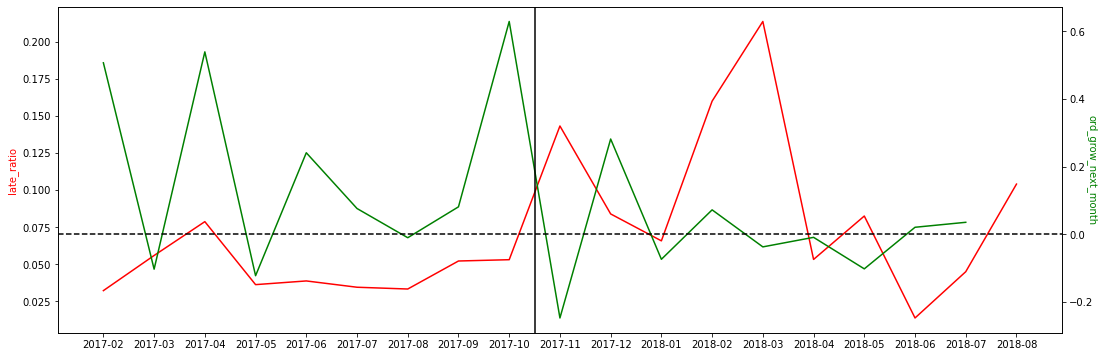

In [19]:
fig, ax1 = plt.subplots(figsize=(18,6))
ax2 = ax1.twinx()
ax1.plot(ord_grow_late['order_purchase_timestamp'].astype(str), ord_grow_late['late'],'r-')
ax2.plot(ord_grow_late['order_purchase_timestamp'].astype(str), ord_grow_late['ord_grow_next_month'],'g-')

plt.axvline(8.5, 0,c='black')

ax1.set_ylabel('late_ratio', color='r')
ax2.set_ylabel('ord_grow_next_month', color='g',rotation=270)

ax2.axhline(0, ls='--',c='black')
plt.show()

***Since 11-2017 late_ratio increased suddenly and at this time order_grow_ratio is in sideway***

***--> Correlation between number of orders & late delivery rate***

## Delivery Time

In [20]:
ord_dist=ord_stt[ord_stt['order_status'].isin(['delivered'])].copy()[['order_id','customer_id']]
ord_dist=pd.merge(ord_dist,ord[['order_id','seller_id']],on='order_id',how='left')
ord_dist=pd.merge(ord_dist,cus[['customer_id','customer_zip_code_prefix']],how='left',on='customer_id').rename(columns={'customer_zip_code_prefix':'cus_zipcode'})
ord_dist=pd.merge(ord_dist,sel[['seller_id','seller_zip_code_prefix']],how='left',on='seller_id').rename(columns={'seller_zip_code_prefix':'sel_zipcode'})

In [21]:
ord_dist=pd.merge(ord_dist,
         loc[['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']],
         how='left',
         left_on='cus_zipcode',
         right_on='geolocation_zip_code_prefix').rename(columns={'geolocation_lat':'cus_lat','geolocation_lng':'cus_lng'}).drop(columns='geolocation_zip_code_prefix')
ord_dist=pd.merge(ord_dist,
         loc[['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']],
         how='left',
         left_on='sel_zipcode',
         right_on='geolocation_zip_code_prefix').rename(columns={'geolocation_lat':'sel_lat','geolocation_lng':'sel_lng'}).drop(columns='geolocation_zip_code_prefix')

In [22]:
# function that calculate the distance between the seller & the buyer
def cal_distance(x):
  cus_lat = radians(x['cus_lat'])
  cus_lng = radians(x['cus_lng'])
  sel_lat = radians(x['sel_lat'])
  sel_lng = radians(x['sel_lng'])

  dlon = sel_lng - cus_lng
  dlat = sel_lat - cus_lat

  a = sin(dlat / 2)**2 + cos(cus_lat) * cos(sel_lat) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = 6373.0 * c #6373 is approximate radius of earth in km
  return round(distance,2)

In [23]:
ord_dist['distance(km)']=ord_dist.apply(cal_distance,axis=1)

ord_dist.drop(columns=['cus_zipcode','sel_zipcode','cus_lat','cus_lng','sel_lat','sel_lng','customer_id'],inplace=True)
dist_day=ord_dist.drop_duplicates().groupby('order_id').sum()[['distance(km)']].reset_index()

In [24]:
purc_day=ord_stt.copy()[['order_id','order_purchase_timestamp','order_delivered_customer_date']]
purc_day['pur_monthyear']=purc_day['order_purchase_timestamp'].dt.to_period('M')
purc_day['pur_week']=purc_day['order_purchase_timestamp'].dt.to_period('W')
purc_day['actual_deli(h)']=round((purc_day['order_delivered_customer_date']-purc_day['order_purchase_timestamp'])/np.timedelta64(1, 'h'),2)
dist_day=pd.merge(dist_day,purc_day[['order_id','pur_monthyear','pur_week','actual_deli(h)']],on='order_id',how='left')

In [25]:
dist_day=dist_day[(dist_day['actual_deli(h)']!=0) & (dist_day['distance(km)']!=0)].copy()
# remove outliners
q1 = ord_dist['distance(km)'].quantile(0.25) # Tính Q1
q3 = ord_dist['distance(km)'].quantile(0.75) # Tính Q3 
 
# calculate the interquartile range
iqr = q3 - q1
iqr
 
# calculate the whisker
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

dist_day=dist_day[dist_day['distance(km)']<upper]
dist_day['hours/10km']=round(dist_day['actual_deli(h)']*10/dist_day['distance(km)'],2)

In [26]:
dist_day.head()

order_id  distance(km) pur_monthyear  \
0  00010242fe8c5a6d1ba2dd792cb16214        301.51       2017-09   
1  00018f77f2f0320c557190d7a144bdd3        585.25       2017-04   
2  000229ec398224ef6ca0657da4fc703e        312.48       2018-01   
3  00024acbcdf0a6daa1e931b038114c75        295.57       2018-08   
4  00042b26cf59d7ce69dfabb4e55b4fd9        646.35       2017-02   

                pur_week  actual_deli(h)  hours/10km  
0  2017-09-11/2017-09-17          182.75        6.06  
1  2017-04-24/2017-04-30          389.19        6.65  
2  2018-01-08/2018-01-14          190.76        6.10  
3  2018-08-06/2018-08-12          147.53        4.99  
4  2017-01-30/2017-02-05          602.74        9.33

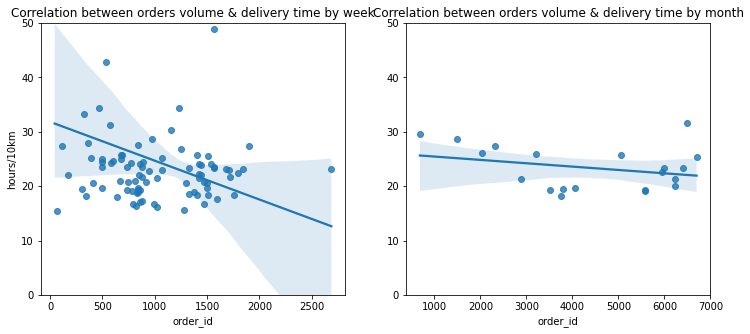

In [27]:
ord_spe_month=dist_day.groupby('pur_monthyear').agg({'order_id':'count','hours/10km':'mean'})
ord_spe_week=dist_day.groupby('pur_week').agg({'order_id':'count','hours/10km':'mean'})

plt.figure(figsize=(12,5))
plt.subplot(121)
sns.regplot(data=ord_spe_week,
                x='order_id',
                y='hours/10km')
plt.title('Correlation between orders volume & delivery time by week')
plt.ylim(0,50)

plt.subplot(122)
sns.regplot(data=ord_spe_month,
                x='order_id',
                y='hours/10km')
plt.ylabel('')
plt.title('Correlation between orders volume & delivery time by month')
plt.ylim(0,50)
plt.show()

***Lack of data, a lot of outliner --> not accuracy with scatter plot so I am gonna draw monthly line chart***

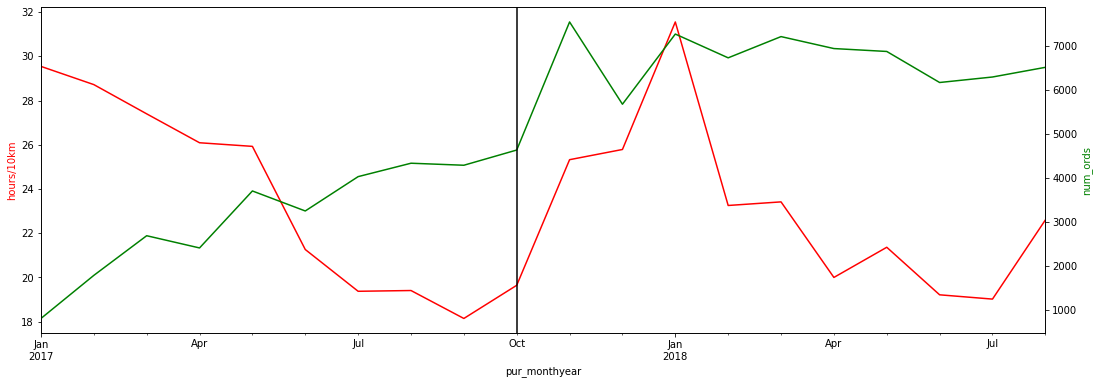

In [28]:
fig, ax1 = plt.subplots(figsize=(18,6))
ax2 = ax1.twinx()

dist_day.groupby('pur_monthyear').mean()['hours/10km'].plot(ax=ax1,color='r')
ord_grow[['order_purchase_timestamp','order_id']].set_index('order_purchase_timestamp')['order_id'].plot(ax=ax2,color='g')

plt.axvline('2017-10', 0,c='black')

ax1.set_ylabel('hours/10km', color='r')
ax2.set_ylabel('num_ords', color='g')

plt.show()

*Look at the chart*

 - **From 01-2017 to 10-2017, time delivery improved (decrease) --> Total order numbers improve (increase) too**

 - **From 10-2017 to 02-2018, time delivery increased strongly --> Orders numbers go sideway**

**--> Why time of delivery decreased since 04-2018 (~19 hours/10km) but orders volume still not improve ?**

**Lead day**

There are 3 period of time:
- Seller confirmed order
- The seller prepares the goods and delivers to the carrier
- Carrier delivery goods to buyer

In [29]:
deli_gap=ord_stt[['order_id','order_status','order_purchase_timestamp']].copy()
deli_gap['seller_cfmed']=round((ord_stt['order_approved_at']-ord_stt['order_purchase_timestamp'])/np.timedelta64(1, 'h'),2)
deli_gap['seller_to_carrier']=round((ord_stt['order_delivered_carrier_date']-ord_stt['order_approved_at'])/np.timedelta64(1, 'h'),2)
deli_gap['carrier_to_buyer']=round((ord_stt['order_delivered_customer_date']-ord_stt['order_delivered_carrier_date'])/np.timedelta64(1, 'h'),2)
deli_gap['cfmed_to_carrier']=round((ord_stt['order_delivered_carrier_date']-ord_stt['order_purchase_timestamp'])/np.timedelta64(1, 'h'),2)
deli_gap['month_year']=deli_gap['order_purchase_timestamp'].dt.to_period('M')

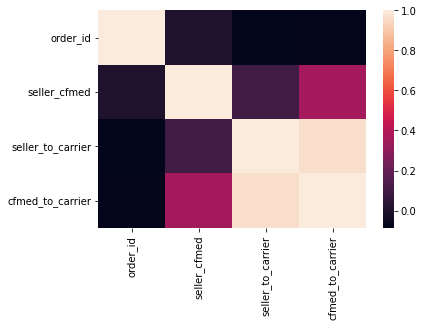

In [30]:
deli_gap_week=deli_gap.groupby(deli_gap['order_purchase_timestamp'].dt.to_period('W')).agg({'order_id':'count','seller_cfmed':'mean',
                                                                                    'seller_to_carrier':'mean','cfmed_to_carrier':'mean'})
sns.heatmap(data=deli_gap_week.corr())

plt.show()

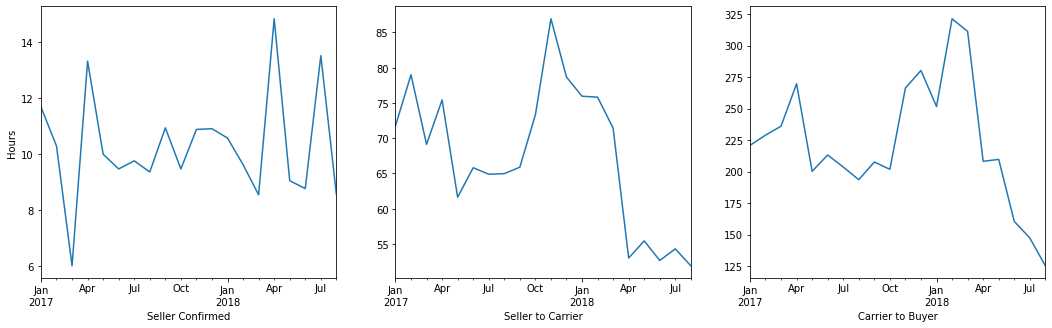

In [31]:
plt.figure(figsize=(18,5))
plt.subplot(131)
deli_gap.groupby('month_year').mean()['seller_cfmed'].plot(xlabel='Seller Confirmed',ylabel='Hours')
plt.subplot(132)
deli_gap.groupby('month_year').mean()['seller_to_carrier'].plot(xlabel='Seller to Carrier')
#plt.axvline('2017-11', 0,c='black')
plt.subplot(133)
deli_gap.groupby('month_year').mean()['carrier_to_buyer'].plot(xlabel='Carrier to Buyer')
plt.show()

In [32]:
seller_to_carrier=pd.concat([dist_day.groupby('pur_monthyear').mean()['actual_deli(h)'],
                  deli_gap.groupby('month_year').mean()['seller_to_carrier']],axis=1)
seller_to_carrier['ratio']=seller_to_carrier['seller_to_carrier']/seller_to_carrier['actual_deli(h)']
round(seller_to_carrier['2017-10':'2017-12']['ratio'].mean()*100,2)

24.99

***--> During the high number of orders period (11/2017) , the seller took a lot of time to prepare the goods ~ 25% of total delivery time (80 hours / 3.3 days)***

## Delivery Fee

**Distance between seller & buyer (How much the customers pay for delivery freight?)**

In [33]:
dist_frei=pd.merge(ord_dist.groupby('order_id').sum()[['distance(km)']].reset_index(),
                  ord[['order_id','price','freight_value']].groupby('order_id').sum().reset_index(),
                  on='order_id',how='left')

dist_frei['frei/10km']=round((dist_frei['freight_value']/dist_frei['distance(km)'])*10,2)
dist_frei=pd.merge(dist_frei,purc_day[['order_id','pur_monthyear','pur_week']],how='left',on='order_id')

# remove outliner
dist_frei=dist_frei[(dist_frei['frei/10km']!=0) & (dist_frei['distance(km)']!=0)].copy()
q1 = ord_dist['distance(km)'].quantile(0.25) 
q3 = ord_dist['distance(km)'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

dist_frei=dist_frei[(dist_frei['distance(km)']<upper) & (dist_frei['distance(km)']>lower)]

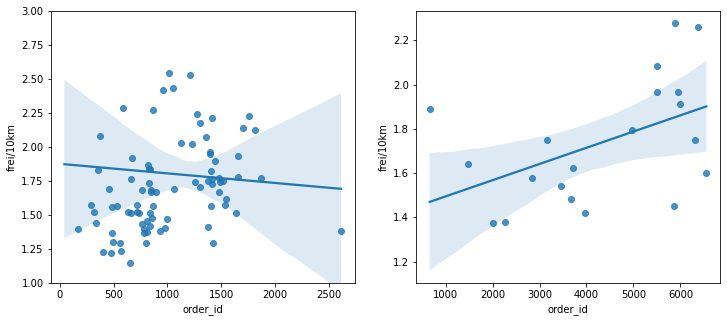

In [34]:
frei_dis_week=dist_frei.groupby('pur_week').agg({'order_id':'count','frei/10km':'mean'})
frei_dis_month=dist_frei.groupby('pur_monthyear').agg({'order_id':'count','frei/10km':'mean'})
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.regplot(data=frei_dis_week,x='order_id',y='frei/10km')
plt.ylim(1,3)
plt.subplot(122)
sns.regplot(data=frei_dis_month,x='order_id',y='frei/10km')
plt.show()

***Lack of data, a lot of outliner --> not accuracy with scatter plot so I am gonna draw monthly line chart***

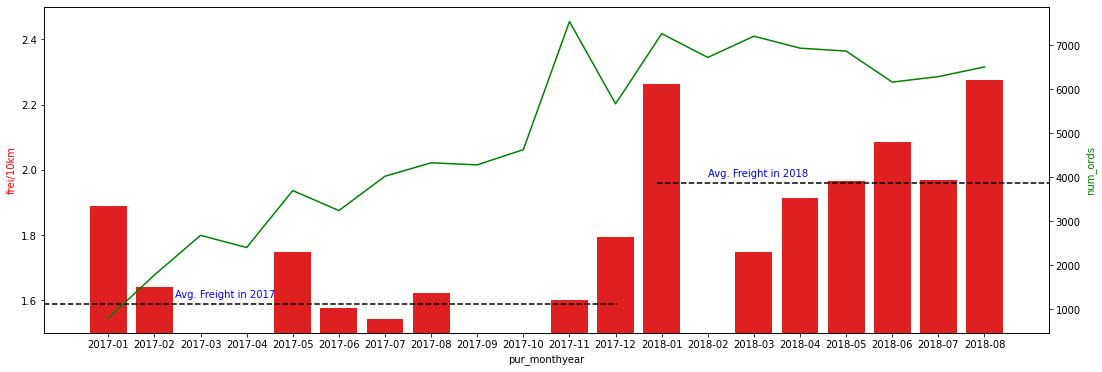

In [35]:
fig, ax1 = plt.subplots(figsize=(18,6))
sns.barplot(data=dist_frei.groupby('pur_monthyear').mean()['frei/10km'].reset_index(),
           x='pur_monthyear',y='frei/10km',ax=ax1,color='r')
ax2 = ax1.twinx()
sns.lineplot(x=(ord_grow[['order_purchase_timestamp','order_id']].set_index('order_purchase_timestamp')['order_id'].index).astype(str),
             y=(ord_grow[['order_purchase_timestamp','order_id']].set_index('order_purchase_timestamp')['order_id'].values),
             ax=ax2,color='g')
ax1.set_ylim(1.5,2.5)
ax2.set_ylabel('num_ords', color='g')
ax1.set_ylabel('frei/10km', color='r')

tmp=dist_frei.groupby('pur_monthyear').mean()['frei/10km'].reset_index()
tmp_2017=tmp[tmp['pur_monthyear']<='2017-12']['frei/10km'].mean()
tmp_2018=tmp[tmp['pur_monthyear']>'2017-12']['frei/10km'].mean()

ax1.axhline(tmp_2017, ls='--',color='black',xmin=0, xmax=0.57)
ax1.text(1.45,tmp_2017+0.02, "Avg. Freight in 2017",c='blue')

ax1.axhline(tmp_2018, ls='--',color='black',xmin=0.61, xmax=1)
ax1.text(13,tmp_2018+0.02, "Avg. Freight in 2018",c='blue')

plt.show()

***Although the delivery time has improved since 03-2018 but the delivery fee has also increased too <--> orders number trend go sideway***

# Conclusion

*5 Key Insights:*

**1. Order growth unusual since 11-2017 go with lots of 1 & 2 star reviews.**

**2. Customers complain the most about 2 things:**

- ***Product's quality (low quality, wrong product,...)***
    
- ***Delivery (Late, not as expected, damage package,...)***
    

**3. Since late delivery rate increase, orders growth go down trend or sideway.**

**4. It takes about 80 hours to prepare the seller's goods to the carrier during peak times, which is 25% of the total delivery time.**

**5. Since 03-2018 delivery time has improved but the cost is increasing, orders number tend to decrease during this period**

# Solution & Evaluation

## Improve Delivery Freight

In [36]:
# calculate delivery fee from one city to all city (You do not need to use the pivot table as I did, groupby can be solved easily :))

city_dis=ord[['order_id','seller_id','freight_value']].groupby(['order_id','seller_id']).mean()['freight_value'].reset_index()
city_dis=pd.merge(city_dis,
         pd.merge(ord_stt[['order_id','customer_id']],cus[['customer_id','customer_city']],how='inner',on='customer_id'),
         on='order_id',
         how='left')
city_dis=pd.merge(city_dis,sel,on='seller_id',how='left').drop(columns=['order_id','seller_id','customer_id','seller_zip_code_prefix','seller_state'])
city_dis.drop(index=city_dis[city_dis['seller_city']=='04482255'].index,inplace=True)

city_dis_pivot=pd.pivot_table(data=city_dis, 
               index='customer_city', 
               columns='seller_city', 
               values='freight_value',
               aggfunc='mean')
city_dis_pivot

seller_city          abadia de goias  afonso claudio  aguas claras df  \
customer_city                                                           
abadia dos dourados              NaN             NaN              NaN   
abadiania                        NaN             NaN              NaN   
abaete                           NaN             NaN              NaN   
abaetetuba                       NaN             NaN              NaN   
abaiara                          NaN             NaN              NaN   
...                              ...             ...              ...   
xinguara                         NaN             NaN              NaN   
xique-xique                      NaN             NaN              NaN   
zacarias                         NaN             NaN              NaN   
ze doca                          NaN             NaN              NaN   
zortea                           NaN             NaN              NaN   

seller_city          alambari  alfenas  almirante tamandare  alvares machado  \
customer_city                                                                  
abadia dos dourados       NaN      NaN                  NaN              NaN   
abadiania                 NaN      NaN                  NaN              NaN   
abaete                    NaN      NaN                  NaN              NaN   
abaetetuba                NaN      NaN                  NaN              NaN   
abaiara                   NaN      NaN                  NaN              NaN   
...                       ...      ...                  ...              ...   
xinguara                  NaN      NaN                  NaN              NaN   
xique-xique               NaN      NaN                  NaN              NaN   
zacarias                  NaN      NaN                  NaN              NaN   
ze doca                   NaN      NaN                  NaN              NaN   
zortea                    NaN      NaN                  NaN              NaN   

seller_city          alvorada  americana  amparo  ...  vicosa  videira  \
customer_city                                     ...                    
abadia dos dourados       NaN        NaN     NaN  ...     NaN      NaN   
abadiania                 NaN        NaN     NaN  ...     NaN      NaN   
abaete                    NaN        NaN     NaN  ...     NaN      NaN   
abaetetuba                NaN        NaN     NaN  ...     NaN      NaN   
abaiara                   NaN        NaN     NaN  ...     NaN      NaN   
...                       ...        ...     ...  ...     ...      ...   
xinguara                  NaN        NaN     NaN  ...     NaN      NaN   
xique-xique               NaN        NaN     NaN  ...     NaN      NaN   
zacarias                  NaN        NaN     NaN  ...     NaN      NaN   
ze doca                   NaN        NaN     NaN  ...     NaN      NaN   
zortea                    NaN        NaN     NaN  ...     NaN      NaN   

seller_city          vila velha  vitoria  vitoria de santo antao  \
customer_city                                                      
abadia dos dourados         NaN      NaN                     NaN   
abadiania                   NaN      NaN                     NaN   
abaete                      NaN      NaN                     NaN   
abaetetuba                  NaN      NaN                     NaN   
abaiara                     NaN      NaN                     NaN   
...                         ...      ...                     ...   
xinguara                    NaN      NaN                     NaN   
xique-xique                 NaN      NaN                     NaN   
zacarias                    NaN      NaN                     NaN   
ze doca                     NaN      NaN                     NaN   
zortea                      NaN      NaN                     NaN   

seller_city          volta redonda  votorantim  votuporanga  xanxere  xaxim  
customer_city                                                                
abadi

In [37]:
city_dis_new=pd.concat([city_dis_pivot.mean(),
                        city_dis_pivot.count()],axis=1).rename(columns={0:'avg_frei_to_city',1:'city_count'})
city_dis_new=pd.merge(sel[['seller_city','seller_state']].drop_duplicates(subset='seller_city'),
                      city_dis_new,
                      how='left',
                      right_on=city_dis_new.index,left_on='seller_city')
print('Top 7 city with highest delivery freight')
print(city_dis_new.sort_values('city_count',ascending=False)[:50].sort_values('avg_frei_to_city',ascending=False)[:10].drop(index=[195,83,139]))
print('-'*100)
print('Top 7 city with lowest delivery freight')
print(city_dis_new.sort_values('city_count',ascending=False)[:50].sort_values('avg_frei_to_city')[:7])

Top 7 city with highest delivery freight
          seller_city seller_state  avg_frei_to_city  city_count
574          ilicinea           MG         42.182657       308.0
11   lauro de freitas           BA         36.427942       210.0
68           londrina           PR         32.707786       202.0
201        uberlandia           MG         30.700540       182.0
399            recife           PE         29.735504       220.0
165           brusque           SC         29.335688       193.0
7            curitiba           PR         27.604603       728.0
----------------------------------------------------------------------------------------------------
Top 7 city with lowest delivery freight
             seller_city seller_state  avg_frei_to_city  city_count
119                 maua           SP         15.435364       199.0
142  sao jose dos campos           SP         17.530209       256.0
75                santos           SP         17.729863       230.0
104              jacarei  

***--> SP state* sellers have a lowest mean of freights to all regions**

**--> Delivery freight in SP state of olists between 18 & 19 BRL, better than average freight. But outside of this area, delivery freight is quite high**

***Solution***: 
- Olists should find Third-party logistics providers to delivery goods that outside of SP state

***Evaluate***: 
- Third-party logistics providers have strong experience, warehousing spread all over the city --> Reduce freight 
  
  Source: https://sifted.com/resources/3pls-reduce-supply-chain-costs/

- Back to 2016, 2017, 2018 when shopee's delivery was not strong enough, they cooperated with 3rd logistic company like: Giaohangnhanh, Giaohangtietkiem and they do not even ship just a order. But Shopee Xpress appeared in recent years and they build their own logistic system

In [38]:
ord_loc=pd.merge(ord_stt[['order_id','customer_id']],
         cus[['customer_id','customer_zip_code_prefix']],
         on='customer_id',
         how='inner')
ord_loc=pd.merge(ord_loc,loc,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',how='left')
ord_loc.dropna(inplace=True)

*Additional infomation*

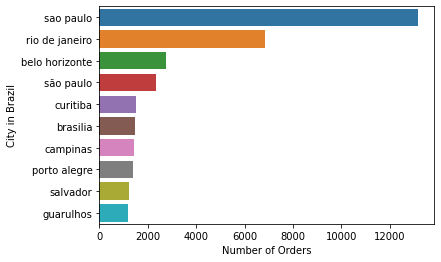

In [39]:
ord_loc_grb=ord_loc.groupby('geolocation_city').count()[['order_id']].sort_values('order_id',ascending=False)[:10]
sns.barplot(data=ord_loc_grb,y=ord_loc_grb.index,x='order_id')
plt.xlabel('Number of Orders')
plt.ylabel('City in Brazil')
plt.show()

In [40]:
# overview orders volume in map 
lat_long=list(zip(ord_loc['geolocation_lat'].tolist(),ord_loc['geolocation_lng'].tolist()))
map=folium.Map(location=[-18.09933756969731, -49.90158547133922], zoom_start=4,tiles='cartodbdark_matter')
FastMarkerCluster(data=lat_long).add_to(map)
map

*Additional infomation: 80% number of orders are in SP state. The closer distance between seller & buyer, the lower the cost*

## Improve Delivery Time

Factors that can impact delivery time include breakdown of transportation, labor shortages, natural disasters, and human errors, ... 

***Source***: https://www.investopedia.com/

  But with dataset we observe that it take a very long time for seller to delivery cargo to carrier (25% of total delivery time) --> Improve this period of time delivery



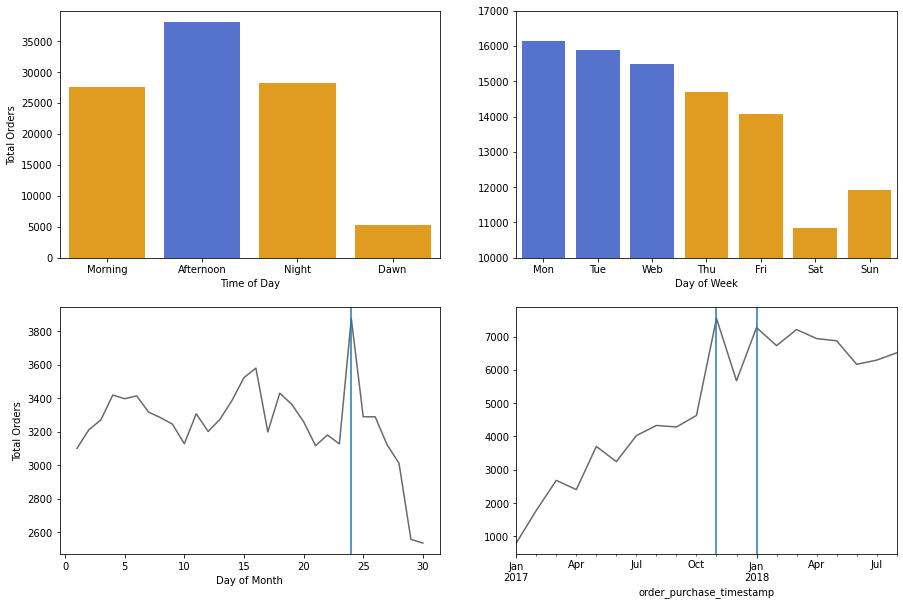

In [41]:
day_week_ord=ord_stt.groupby(ord_stt['order_purchase_timestamp'].dt.dayofweek).count()['order_id']
day_week_ord.set_axis(['Mon', 'Tue','Web','Thu','Fri','Sat','Sun'],inplace=True)
day_week_ord=day_week_ord.reset_index().rename(columns={'index':'day_of_week','order_id':'total_orders'})

month_ord=ord_stt.groupby(ord_stt['order_purchase_timestamp'].dt.month).count()['order_id']
month_ord=month_ord.reset_index().rename(columns={'order_purchase_timestamp':'month_of_year','order_id':'total_orders'})

time_of_day=ord_stt.copy()[['order_id','order_purchase_timestamp']]
time_of_day['hour']=time_of_day['order_purchase_timestamp'].dt.hour

day_of_month=ord_stt.copy()[['order_id','order_purchase_timestamp']]
day_of_month['day_of_month']=day_of_month['order_purchase_timestamp'].dt.day
day_of_month=day_of_month.groupby('day_of_month').count()['order_id'].reset_index()
day_of_month.drop(index=30,inplace=True)
def day_time(x):
  if x<=6:
    return 'Dawn'
  if x<=12:
    return 'Morning'
  if x<=18:
    return 'Afternoon'
  if x<=24:
    return 'Night'
time_of_day['time_of_day']=time_of_day['hour'].apply(day_time)
time_of_day=time_of_day.groupby('time_of_day').count()['order_id'].reset_index()

plt.figure(figsize=(15,10))
plt.subplot(222)
day_of_week_color=[]
for i in range(0,7):
  if i<3:
    day_of_week_color.append('royalblue')
  else:
    day_of_week_color.append('orange')
sns.barplot(data=day_week_ord,
            x='day_of_week',
            y='total_orders',palette=day_of_week_color) 
plt.xlabel('Day of Week')  
plt.ylim(10000,17000)
plt.ylabel('')    

plt.subplot(224) 
ord_stt.groupby(ord_stt['order_purchase_timestamp'].dt.to_period('M')).count()['order_id'].plot(color='dimgray')
plt.axvline('2017-11')
plt.axvline('2018-01')
plt.subplot(221) 
sns.barplot(data=time_of_day,
            x='time_of_day',
            y='order_id',
            order=['Morning','Afternoon','Night','Dawn'],palette=['orange','royalblue','orange','orange'])  
plt.ylabel('Total Orders')
plt.xlabel('Time of Day')

plt.subplot(223) 
sns.lineplot(data=day_of_month,
            x='day_of_month',
            y='order_id',color='dimgray')  
plt.axvline(24)
plt.ylabel('Total Orders')
plt.xlabel('Day of Month')  

plt.show()

--------------------------------------------------------------------------------

***Solution***:

- Set target for seller to delivery cargo to carrier before period of time (before 2 days)

***Evaluate***: 
- Top e-commerce company like shopee, lazada have applied target for goods preparation time. Ex: Shopee before 1.5 days, lazada before 2 days
- Warn seller about peak day time (Holiday, Time of day, ...) to increase target performance
    - Holiday: Black Friday, Valentine, ...

    - Time of day: Afternoon

    - Day of week: Beginning of the week
    
    - Day of month: 1 week before the end of month
    
***Source***:

https://banhang.shopee.vn/edu/article/3807

https://sellercenter.lazada.vn/seller/helpcenter/giao-hang-dung-han-sla-sot-sla-la-gi-7213.html

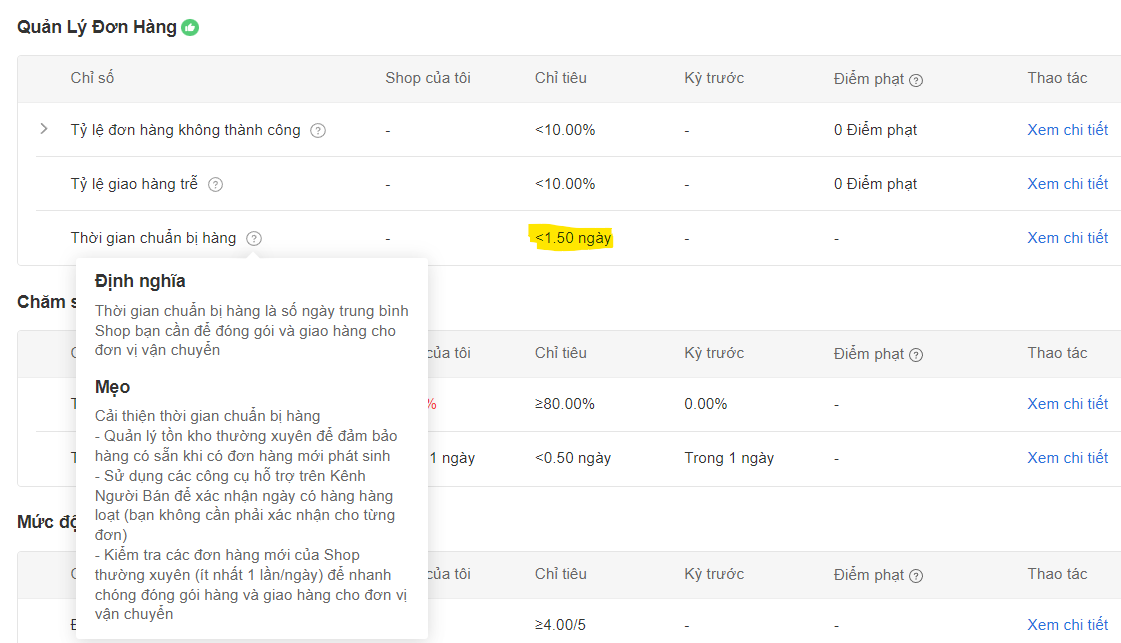

## Predict Delivery Time - Improve Late Delivery Rate

***Solution:***  Build a model to predict delivery time because the more accurate the delivery time prediction, the lower the late delivery rate

----------------------------------------------------------------------------------------------------------------------

Listed of necessary features used to predict delivery time

***Dependent variable*** :
- Actual delivery time

***Independent variables***:
- Distance of delivery
- Freight
- Product size
- Product weight
- Seller & buyer state
- Purchase day of month, day of week, time of day

**Create data for build model**

In [42]:
# product (weight, volume)
prd_size=prd.copy()[['product_id','product_weight_g','product_length_cm','product_height_cm','product_width_cm']]
prd_size['vol(cm3)']=prd_size['product_width_cm']*prd_size['product_length_cm']*prd_size['product_height_cm']
prd_size=prd_size.drop(columns=['product_length_cm','product_height_cm','product_width_cm']).rename(columns={'product_weight_g':'weight(g)'})

prd_size=pd.merge(ord[['order_id','product_id']],prd_size,how='left',on='product_id')
prd_size=prd_size.groupby('order_id').mean()[['weight(g)','vol(cm3)']].reset_index()

In [43]:
# time of day, day of week, day of month
time_pur=ord_stt.copy()[['order_id','order_purchase_timestamp','order_delivered_customer_date']]
time_pur['timeofday']=time_pur['order_purchase_timestamp'].dt.hour.apply(day_time)
time_pur['dayofweek']=time_pur['order_purchase_timestamp'].dt.dayofweek
time_pur['dayofmonth']=time_pur['order_purchase_timestamp'].dt.day
time_pur['actual_deli_day']=(time_pur['order_delivered_customer_date']-time_pur['order_purchase_timestamp']).dt.days
time_pur.drop(columns=['order_purchase_timestamp','order_delivered_customer_date'],inplace=True)

In [44]:
# delivery freight
frei=ord.groupby('order_id').sum()['freight_value'].reset_index()

In [45]:
# customer & seller geographic
cus_geo=pd.merge(cus[['customer_id','customer_zip_code_prefix','customer_state']],
         loc[['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']],
         how='left',
         left_on='customer_zip_code_prefix',
         right_on='geolocation_zip_code_prefix').drop(columns=['customer_zip_code_prefix','geolocation_zip_code_prefix']).rename(columns={'geolocation_lat':'cus_lat',
                                                                                                                                          'geolocation_lng':'cus_lng'})
sel_geo=pd.merge(sel[['seller_id','seller_zip_code_prefix','seller_state']],
                 loc[['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']],
                 how='left',
                 left_on='seller_zip_code_prefix',
                 right_on='geolocation_zip_code_prefix').drop(columns=['seller_zip_code_prefix','geolocation_zip_code_prefix']).rename(columns={'geolocation_lat':'sel_lat',
                                                                                                                                          'geolocation_lng':'sel_lng'})
tmp=pd.merge(ord_stt[['order_id','customer_id']],ord[['order_id','seller_id']],on='order_id',how='right')
tmp=pd.merge(tmp,cus_geo,how='left',on='customer_id')
tmp=pd.merge(tmp,sel_geo,how='left',on='seller_id')
tmp['distance']=tmp.apply(cal_distance,axis=1)
cus_sel_geo=tmp.drop(columns=['customer_id','seller_id','cus_lat','cus_lng','sel_lat','sel_lng'])
cus_sel_geo=cus_sel_geo[~cus_sel_geo['order_id'].isin(cus_sel_geo[cus_sel_geo['order_id'].duplicated()]['order_id'].unique())]

In [46]:
# final data
model_data=pd.merge(pd.merge(pd.merge(prd_size,frei,on='order_id',how='inner'),time_pur,how='inner',on='order_id'),
         cus_sel_geo,
         on='order_id',
         how='right')
model_data=model_data.reindex(columns=['order_id','actual_deli_day','weight(g)','vol(cm3)','distance','freight_value','timeofday','dayofweek','dayofmonth','customer_state','seller_state'])      

In [47]:
# normalize data between 0 and 1 for 4 feature: weight(g), vol(cm3), distance, freight_value
scaler = MinMaxScaler()
numerical_features = ['weight(g)','vol(cm3)', 'distance','freight_value']
scaler = MinMaxScaler()
model_data.loc[:, numerical_features] = scaler.fit_transform(model_data[numerical_features])

In [48]:
# onehot encoding
encode_features = ['timeofday','dayofweek','dayofmonth','customer_state','seller_state']
model_data = pd.get_dummies(model_data, columns = encode_features)

In [49]:
# clean data 
model_data.dropna(inplace=True)
model_data=model_data.reset_index().drop(columns='index')

In [50]:
# select feature and target variable
X=model_data.drop(columns=['actual_deli_day','order_id'])
y=model_data['actual_deli_day']
# split the dataset. 80% train & 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# building model
lr=LinearRegression()
# train model
lr.fit(X_train, y_train)
# test model
y_pred=lr.predict(X_test)

In [51]:
# evaluate performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.464862225966281
Mean Squared Error: 79.03278607648578
Root Mean Squared Error: 8.89003858689521


In [52]:
ord_est=ord_stt.copy()
ord_est.drop(columns=['order_status','order_approved_at','order_delivered_carrier_date'],inplace=True)
ord_est['purch_day']=ord_est['order_purchase_timestamp'].dt.to_period('D')
ord_est['purch_day']=pd.to_datetime(ord_est['purch_day'].astype(str))
ord_est['est_day']=(ord_est['order_estimated_delivery_date']-ord_est['purch_day']).dt.days
ord_est['actual_day']=(ord_est['order_delivered_customer_date']-ord_est['purch_day']).dt.days
ord_est.drop(columns=['order_delivered_customer_date','order_estimated_delivery_date','purch_day'],inplace=True)
ord_est['safe_gap']=ord_est['est_day']-ord_est['actual_day']

In [53]:
print('Average day between actual and est delivery time :',round(ord_est[ord_est['safe_gap']>0]['safe_gap'].mean(),2),'days')

Average day between actual and est delivery time : 13.64 days


***Evaluate performance:*** The gap between actual & estimate delivery time (MAE) is
*   With this model: 5.46 days
*   Model of olists: 13.64 days

In [54]:
ord_test=model_data[model_data.index.isin(y_test.index)]['order_id'].values
ord_test
olst_delivery=ord_ontime[ord_ontime['order_id'].isin(ord_test)]

model_eval=pd.DataFrame(y_pred,y_test).reset_index().rename(columns={0:'pred_actu'})
model_eval['est_time']=model_eval['pred_actu']+olst_delivery[olst_delivery['gap']>0]['gap'].mean()
def late_check(x):
  if x['actual_deli_day']>x['est_time']:
    return 1
  elif x['actual_deli_day']<=x['est_time']:
    return 0
model_eval['late_binary']=model_eval.apply(late_check,axis=1)

print('Predict model delivery late rate in testing data is  ',round(model_eval['late_binary'].mean(),2)*100,'%')
print('Olists delivery late rate in testing data is ',round((olst_delivery['late'].mean())*100,2),'%')

Predict model delivery late rate in testing data is   6.0 %
Olists delivery late rate in testing data is  8.11 %


In [55]:
# interpret model
import statsmodels.api as sm

X2 = sm.add_constant(X_train)
model_stats = sm.OLS(y_train.values.reshape(-1,1), X2).fit()
model_stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     216.1
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:28:38   Log-Likelihood:            -2.4461e+05
No. Observations:               68922   AIC:                         4.894e+05
Df Residuals:                   68831   BIC:                         4.902e+05
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.7985      0.373     18.217      0.000       6.067       7.530
weight(g)               6.3121      0.626     10.089      0.000       5.086       7.538
vol(cm3)                2.7065      0.716      3.780      0.000       1.303       4.110
distance               47.7285      1.038     45.977      0.000      45.694      49.763
freight_value          -0.4463      1.299     -0.343      0.731      -2.993       2.101
timeofday_Afternoon     1.8284      0.108     16.971      0.000       1.617       2.040
timeofday_Dawn          1.7962      0.146     12.323      0.000       1.510       2.082
timeofday_Morning       1.5765      0.111     14.260      0.000       1.360       1.793
timeofday_Night         1.5975      0.110     14.458      0.000       1.381       1.814
dayofweek_0             0.4014      0.092      4.347      0.000       0.220       0.582
dayofweek_1             0.4890      0.093      5.273      0.000       0.307       0.671
dayofweek_2             0.8482      0.093      9.089      0.000       0.665       1.031
dayofweek_3             1.2655      0.095     13.383      0.000       1.080       1.451
dayofweek_4             1.8028      0.096     18.713      0.000       1.614       1.992
dayofweek_5             1.5289      0.104     14.751      0.000       1.326       1.732
dayofweek_6             0.4627      0.101      4.592      0.000       0.265       0.660
dayofmonth_1            0.2239      0.179      1.254      0.210      -0.126       0.574
dayofmonth_2            0.1583      0.177      0.895      0.371      -0.189       0.505
dayofmonth_3           -0.1417      0.174     -0.813      0.416      -0.484       0.200
dayofmonth_4            0.2770      0.170      1.625      0.104      -0.057       0.611
dayofmonth_5            0.4551      0.171      2.660      0.008       0.120       0.790
dayofmonth_6            0.6936      0.172      4.027      0.000       0.356       1.031
dayofmonth_7            0.1036      0.172      0.601      0.548      -0.234       0.441
dayofmonth_8           -0.0056      0.175     -0.032      0.975      -0.348       0.337
dayofmonth_9            0.0227      0.175      0.130      0.897      -0.321       0.366
dayofmonth_10           0.1081      0.178      0.608      0.543      -0.241       0.457
dayofmonth_11           0.2230      0.173      1.292      0.196      -0.115       0.561
dayofmonth_12           0.7232      0.174      4.145      0.000       0.381       1.065
dayofmonth_13          -0.1103      0.175     -0.632      0.528      -0.453       0.232
dayofmonth_14          -0.0505      0.171     -0.296      0.767      -0.385       0.284
dayofmonth_15           0.2276      0.169      1.347      0.178      -0.103       0.559
dayofmonth_16          -0.2336      0.166     -1.407      0.159      -0.559       0.092
day